<a href="https://colab.research.google.com/github/jiya-0905/subset_selection_problem/blob/main/Clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from google.colab import files

# Configuration dictionary
CONFIG = {
    'preprocessing_techniques': ['none', 'normalization', 'standardization',
                               'pca', 'stand_norm', 'stand_pca'],
    'n_clusters_list': [3, 4, 5],
    'metrics': ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin'],
    'algorithms': ['K-Means', 'Hierarchical', 'Mean Shift']
}

In [ ]:
def apply_preprocessing(X, technique):
    """Apply different preprocessing techniques to the data"""
    if technique == 'none':
        return X.copy()
    elif technique == 'normalization':
        return normalize(X)
    elif technique == 'standardization':
        return StandardScaler().fit_transform(X)
    elif technique == 'pca':
        return PCA(n_components=min(X.shape[1], 2)).fit_transform(X)
    elif technique == 'stand_norm':
        X_scaled = StandardScaler().fit_transform(X)
        return normalize(X_scaled)
    elif technique == 'stand_pca':
        X_scaled = StandardScaler().fit_transform(X)
        return PCA(n_components=min(X.shape[1], 2)).fit_transform(X_scaled)
    return X.copy()

def evaluate_clustering(X, labels):
    """Calculate clustering evaluation metrics"""
    try:
        if len(np.unique(labels)) < 2:
            return np.nan, np.nan, np.nan

        silhouette = silhouette_score(X, labels)
        calinski = calinski_harabasz_score(X, labels)
        davies = davies_bouldin_score(X, labels)
        return silhouette, calinski, davies
    except:
        return np.nan, np.nan, np.nan

def perform_meanshift_clustering(X):
    """Perform Mean Shift clustering with proper bandwidth estimation"""
    try:
        bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=min(500, X.shape[0]))
        if bandwidth == 0:
            bandwidth = np.mean(np.std(X, axis=0))

        meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = meanshift.fit_predict(X)
        return evaluate_clustering(X, labels)
    except:
        return np.nan, np.nan, np.nan

In [ ]:
def perform_clustering_analysis(X):
    """Perform the complete clustering analysis"""
    results = []

    for prep_technique in CONFIG['preprocessing_techniques']:
        X_processed = apply_preprocessing(X, prep_technique)

        for n_clusters in CONFIG['n_clusters_list']:
            # K-Means
            try:
                kmeans = KMeans(n_clusters=n_clusters, random_state=42)
                kmeans_labels = kmeans.fit_predict(X_processed)
                kmeans_scores = evaluate_clustering(X_processed, kmeans_labels)
            except:
                kmeans_scores = (np.nan, np.nan, np.nan)

            # Hierarchical
            try:
                hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
                hierarchical_labels = hierarchical.fit_predict(X_processed)
                hierarchical_scores = evaluate_clustering(X_processed, hierarchical_labels)
            except:
                hierarchical_scores = (np.nan, np.nan, np.nan)

            # Store results
            for algo, scores in [('K-Means', kmeans_scores),
                               ('Hierarchical', hierarchical_scores)]:
                results.append({
                    'Preprocessing': prep_technique,
                    'n_clusters': n_clusters,
                    'Algorithm': algo,
                    'Silhouette': scores[0],
                    'Calinski-Harabasz': scores[1],
                    'Davies-Bouldin': scores[2]
                })

        # Mean Shift
        meanshift_scores = perform_meanshift_clustering(X_processed)
        results.append({
            'Preprocessing': prep_technique,
            'n_clusters': 'auto',
            'Algorithm': 'Mean Shift',
            'Silhouette': meanshift_scores[0],
            'Calinski-Harabasz': meanshift_scores[1],
            'Davies-Bouldin': meanshift_scores[2]
        })

    return pd.DataFrame(results)

def format_results_table(results_df):
    """Format results into tables similar to the sample, with clusters and preprocessing techniques"""
    formatted_tables = []

    prep_mapping = {
        'none': 'No Data Processing',
        'normalization': 'Using Normalization',
        'standardization': 'Using Transform',
        'pca': 'Using PCA',
        'stand_norm': 'Using T+N',
        'stand_pca': 'T+N+PCA'
    }

    for algorithm in CONFIG['algorithms']:
        algo_results = results_df[results_df['Algorithm'] == algorithm].copy()

        # Create a MultiIndex with Preprocessing and Cluster Numbers
        columns = pd.MultiIndex.from_product([
            list(prep_mapping.values()),  # Preprocessing techniques
            [f'c={c}' for c in CONFIG['n_clusters_list']]  # Cluster values (c=3, c=4, c=5)
        ])

        # Initialize the table with metrics as rows and our columns
        formatted_table = pd.DataFrame(index=CONFIG['metrics'], columns=columns)

        for prep in prep_mapping:
            prep_results = algo_results[algo_results['Preprocessing'] == prep]

            for n_cluster in CONFIG['n_clusters_list']:
                cluster_results = prep_results[prep_results['n_clusters'] == n_cluster]

                # Check if we have data for this preprocessing and cluster combo
                if not cluster_results.empty:
                    for metric in CONFIG['metrics']:
                        value = cluster_results[metric].iloc[0]
                        formatted_table.loc[metric, (prep_mapping[prep], f'c={n_cluster}')] = \
                            'NA' if pd.isna(value) else f'{value:.3f}'

        formatted_tables.append((algorithm, formatted_table))

    return formatted_tables

In [ ]:
def save_and_visualize_results(formatted_tables):
    excel_filename='clustering_results_v2.xlsx'
    plot_filename='clustering_comparison_v2.png'
    """Save results to Excel and create visualization with proper cluster and preprocessing labels"""

    # Save to Excel
    with pd.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        workbook = writer.book

        header_format = workbook.add_format({
            'bold': True,
            'text_wrap': True,
            'valign': 'top',
            'border': 1
        })

        cell_format = workbook.add_format({
            'text_wrap': True,
            'border': 1
        })

        for algorithm, table in formatted_tables:
            sheet_name = algorithm.replace(' ', '_')[:31]  # Excel sheet names must be <= 31 characters
            table.to_excel(writer, sheet_name=sheet_name)

            worksheet = writer.sheets[sheet_name]

            for col_num, (prep, cluster) in enumerate(table.columns):
                worksheet.write(0, col_num + 1, prep, header_format)
                worksheet.write(1, col_num + 1, cluster, header_format)

            worksheet.set_column(0, 0, 20)
            worksheet.set_column(1, len(table.columns), 15)

    # Create visualization (matplotlib)
    fig, axes = plt.subplots(len(formatted_tables), 1, figsize=(15, len(formatted_tables) * 5))
    fig.suptitle('Performance using different clustering techniques on various parameters',
                 y=0.95, fontsize=14)

    if len(formatted_tables) == 1:
        axes = [axes]  # Ensure axes is iterable even with one plot

    for idx, (algorithm, table) in enumerate(formatted_tables):
        ax = axes[idx]
        ax.axis('tight')
        ax.axis('off')

        # Display table with cluster counts and preprocessing methods properly formatted
        table_obj = ax.table(cellText=table.values,
                             rowLabels=table.index,
                             colLabels=[f'{prep}\n{cluster}' for prep, cluster in table.columns],
                             cellLoc='center',
                             loc='center')

        table_obj.auto_set_font_size(False)
        table_obj.set_fontsize(9)
        table_obj.scale(1.2, 1.5)

        ax.set_title(f'Using {algorithm}\n ', pad=20)

    plt.tight_layout()
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    files.download(plot_filename)
    plt.show()

Loading Iris dataset...
Performing clustering analysis...
Formatting results...
Saving and visualizing results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

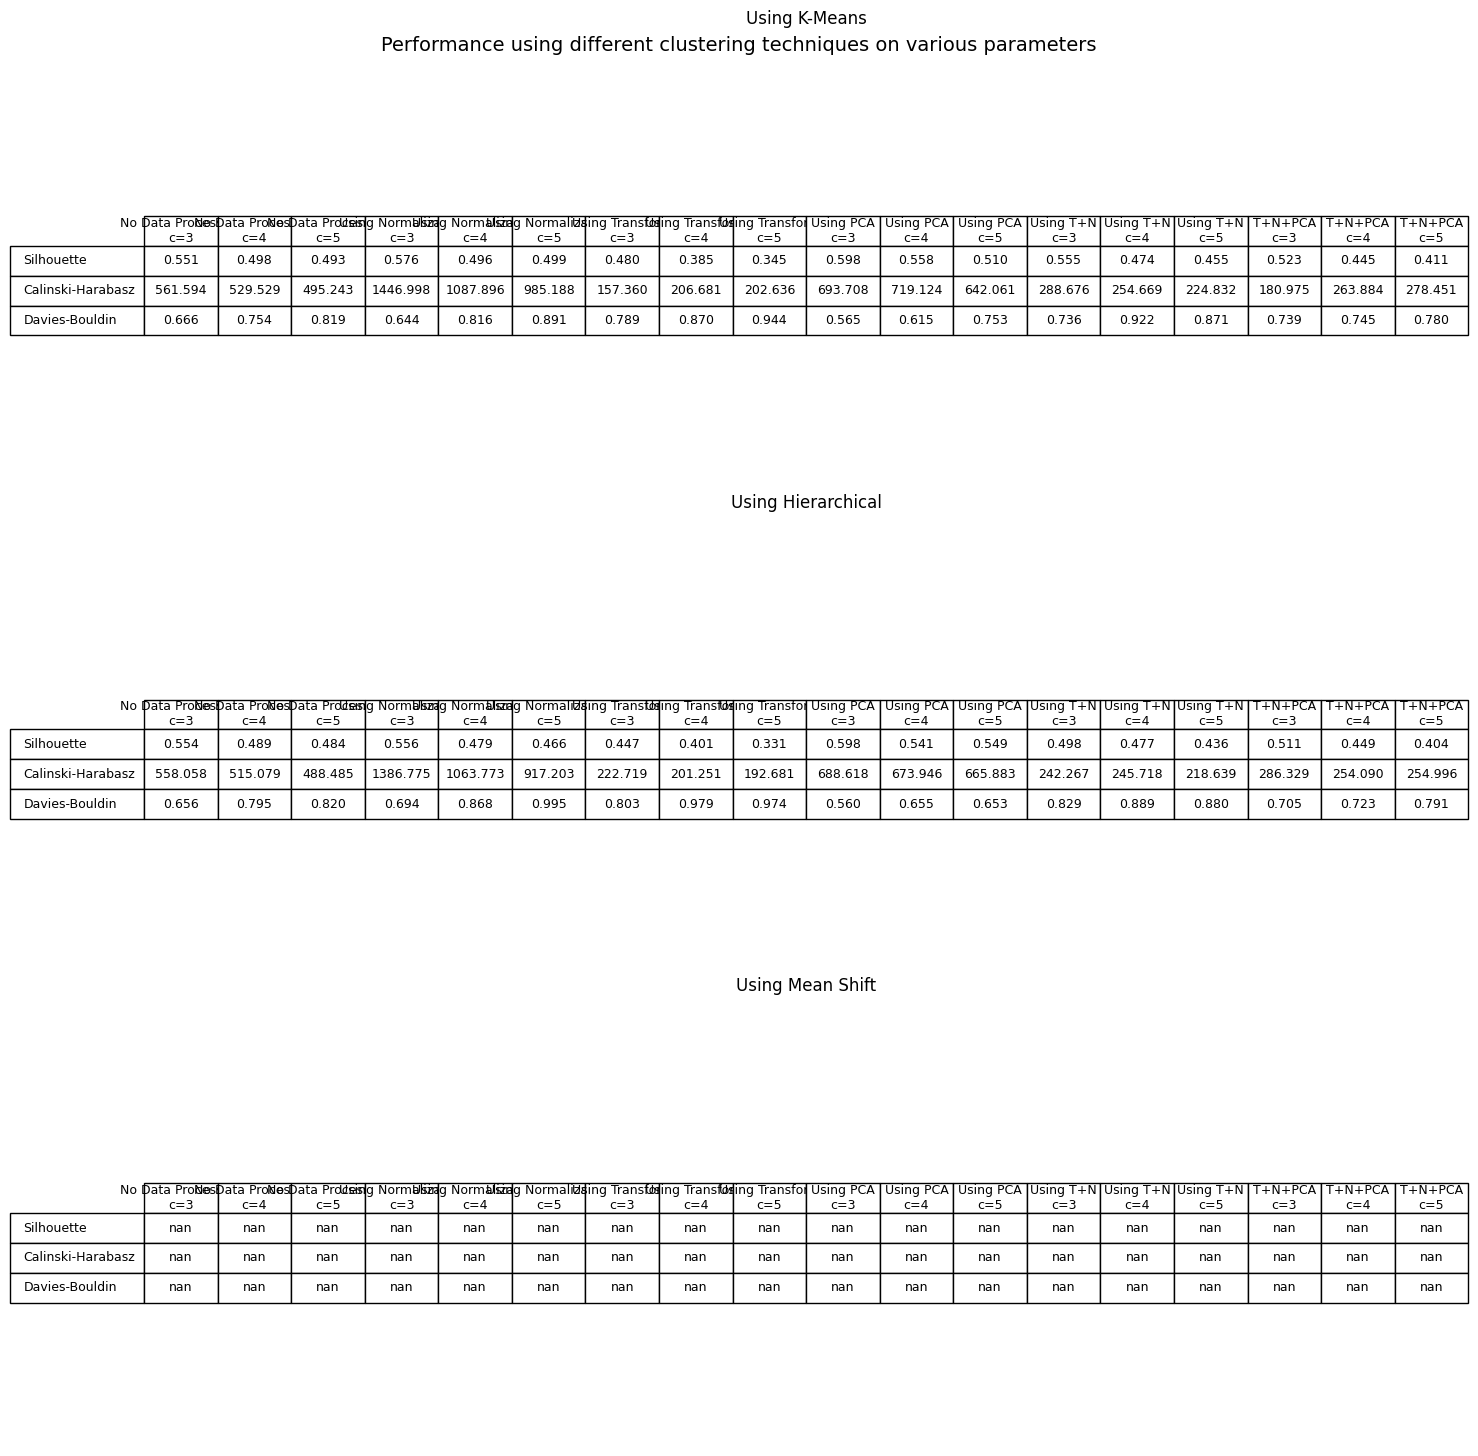

Analysis complete!


In [ ]:
def main():
    # Load the Iris dataset
    print("Loading Iris dataset...")
    iris = load_iris()
    X = iris.data

    # Perform analysis
    print("Performing clustering analysis...")
    results_df = perform_clustering_analysis(X)

    # Format results
    print("Formatting results...")
    formatted_tables = format_results_table(results_df)

    # Save and visualize results
    print("Saving and visualizing results...")
    save_and_visualize_results(formatted_tables)

    print("Analysis complete!")

# Run the analysis
main()